In [1]:
from import_all import *

In [2]:
file_path1 = '../emg+dataset+in+lower+limb/SEMG_DB1/A_TXT/7Amar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index/1000
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

#Normalisation des données
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])

data["FX"]=abs(data["FX"])

print(data.head())

         RF        BF        VM        ST    FX   Time
0  0.011647  0.000997 -0.005829  0.009968  11.4  0.000
1  0.005891  0.003755  0.008711 -0.050023   9.9  0.001
2 -0.009317  0.002720  0.015062 -0.094671   9.8  0.002
3 -0.020563  0.000969  0.024883 -0.124856   9.3  0.003
4 -0.025487 -0.007309  0.036078 -0.146828   8.9  0.004


In [3]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = peaks[i] - shift_amount
    adjusted_peaks.append(adjusted_start)

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(f'Débuts de cycles ajustés : {adjusted_peaks}')

# Verification du premier cycle
print(len(adjusted_peaks))
for i in range(len(adjusted_peaks)):
    if adjusted_peaks[0] < 0 :
        adjusted_peaks.pop(0)
        print(f'Premier cycle supprimé : {adjusted_peaks}')
    else:
        print(f'Premier cycle valide : {adjusted_peaks}')
        break

cycle_lengths = np.diff(adjusted_peaks)
mean_cycle_length = np.mean(cycle_lengths)

# Calcul du temps moyen des cycles **normaux** (excluant les cycles corrompus)
normal_cycle_times = [t for t in cycle_lengths if t > 1000]
mean_normal_cycle_time = np.mean(normal_cycle_times)



print(f'Temps pour chaque cycle : {cycle_lengths}')
print(f'Temps moyen des cycles normaux : {mean_normal_cycle_time:.2f}')

#Détection et correction des cycles anormaux
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = (end_time - start_time)*1000


    if cycle_time >= 1.50 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Nombre de nouveaux cycles
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, divisé en {num_splits} cycles.')

        # Ajout des nouveaux débuts de cycle répartis uniformément
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'][1]*1000 - data['Time'][0]*1000))
            new_adjusted_peaks.append(new_peak)
    elif cycle_time <= 0.50 * mean_normal_cycle_time:
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, supprimé.')
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Ajout du dernier pic s'il n'a pas été traité
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Affichage des nouveaux débuts de cycles
print(f'Nouveaux débuts de cycles ajustés : {adjusted_peaks}')

# Début d'un nouveau cycle même si il n'y a pas de peak
if adjusted_peaks[-1]+int(np.mean(np.diff(adjusted_peaks))) < len(data):
    adjusted_peaks.append(adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))))
    print(f'Ajout d\'un début de nouveau cycle : {adjusted_peaks}')
else:
    print(f'Aucun nouveau cycle ajouté : {adjusted_peaks}')

# Suppression des 3 premiers et 3 derniers cycles si le nombre total de cycles est supérieur à 20
if len(adjusted_peaks) > 20:
    adjusted_peaks = adjusted_peaks[3:-3]
    print(f'Suppression des 3 premiers et 3 derniers cycles : {adjusted_peaks}')

Nombre de débuts de cycles ajustés : 14
Débuts de cycles ajustés : [285, 289, 1505, 2720, 3959, 5204, 8022, 8029, 9273, 10568, 11810, 13100, 14392, 14396]
14
Premier cycle valide : [285, 289, 1505, 2720, 3959, 5204, 8022, 8029, 9273, 10568, 11810, 13100, 14392, 14396]
Temps pour chaque cycle : [   4 1216 1215 1239 1245 2818    7 1244 1295 1242 1290 1292    4]
Temps moyen des cycles normaux : 1409.60
Cycle anormal détecté entre 0.28s et 0.29s, supprimé.
Cycle anormal détecté entre 5.20s et 8.02s, divisé en 2 cycles.
Cycle anormal détecté entre 8.02s et 8.03s, supprimé.
Cycle anormal détecté entre 14.39s et 14.40s, supprimé.
Nouveaux débuts de cycles ajustés : [289, 1505, 2720, 3959, 5204, 6613, 8029, 9273, 10568, 11810, 13100, 14396]
Ajout d'un début de nouveau cycle : [289, 1505, 2720, 3959, 5204, 6613, 8029, 9273, 10568, 11810, 13100, 14396, 15678]


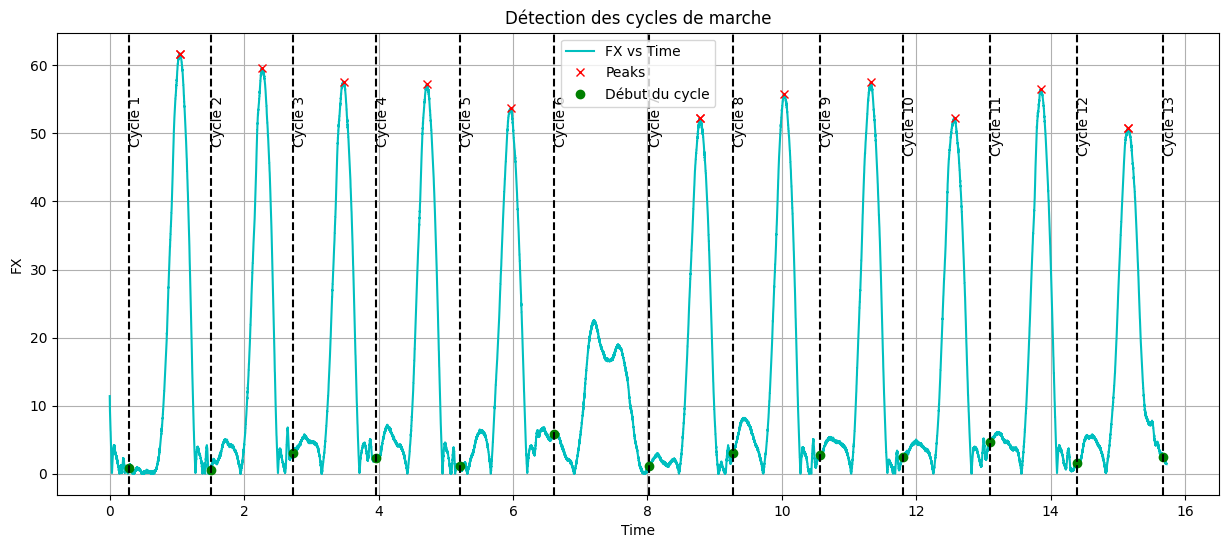

In [4]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# On calcul le temps de chaque cycle et on divise par la fréquence d'échantillonnage pour obtenir le temps en secondes
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Calcul du temps de cycle moyen
average_cycle_time = np.mean(cycle_durations)

print(f"Durée de chaque cycles (en secondes): {cycle_durations}")
print(f"Temps moyen de cycle (en secondes): {average_cycle_time}")

Durée de chaque cycles (en secondes): [1.216 1.215 1.239 1.245 1.409 1.416 1.244 1.295 1.242 1.29  1.296 1.282]
Temps moyen de cycle (en secondes): 1.2824166666666665


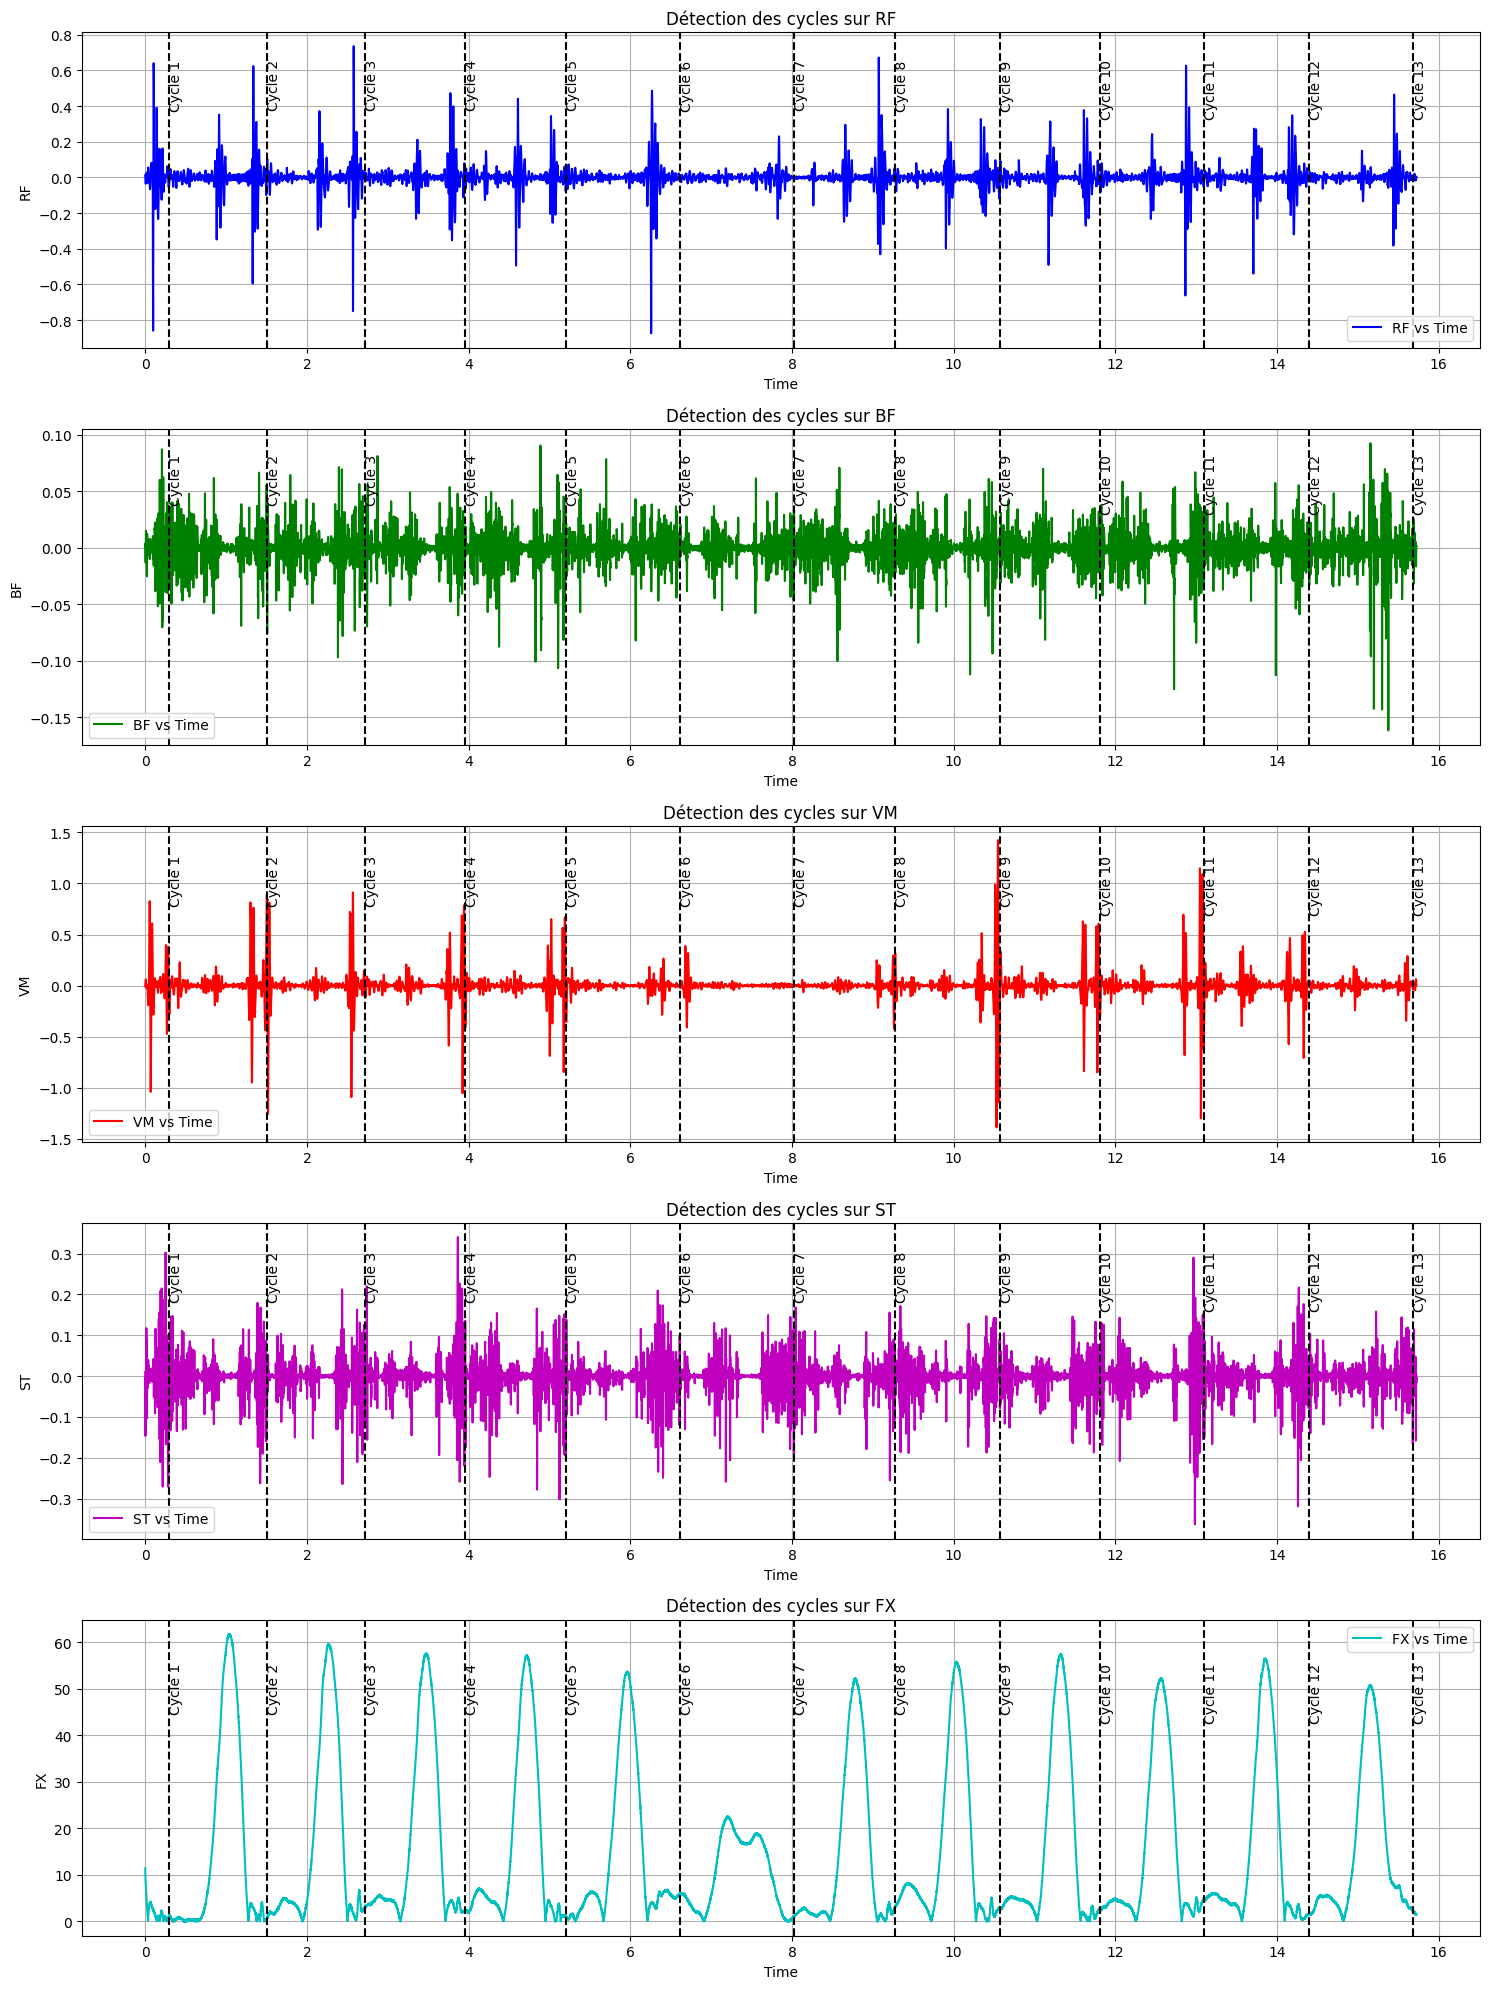

In [6]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) pour chaque cycle
rms_values_RF = []
rms_values_BF = []
rms_values_VM = []
rms_values_ST = []
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)


print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

mean_rms_RF = np.mean(rms_values_RF)
mean_rms_BF = np.mean(rms_values_BF)
mean_rms_VM = np.mean(rms_values_VM)
mean_rms_ST = np.mean(rms_values_ST)

print(f'Mean RMS RF: {mean_rms_RF:.4f}')
print(f'Mean RMS BF: {mean_rms_BF:.4f}')
print(f'Mean RMS VM: {mean_rms_VM:.4f}')
print(f'Mean RMS ST: {mean_rms_ST:.4f}')

[0.08649544753340148, 0.08718816766042833, 0.07337067665856743, 0.0745517856916945, 0.08057480642603622, 0.03330179562955437, 0.08696478478074335, 0.06717267522679346, 0.07468524029394195, 0.08073184292011244, 0.07647460392921052, 0.05575937981569755]
[0.01487214766872259, 0.016238287058369896, 0.013540275604454961, 0.01723307320310651, 0.012278552167601214, 0.010296774154434906, 0.013536039301030239, 0.015458657015614106, 0.012812898755710584, 0.01566078488483387, 0.012780376853102666, 0.018284263459785996]
[0.15079590400510814, 0.18463330892169902, 0.13940892634550925, 0.1341308049463736, 0.05697797857313338, 0.05271886040197554, 0.0544889344369198, 0.20378620369552736, 0.14234031610652828, 0.1848984164342363, 0.12664949980114543, 0.05660482667954639]
[0.04280044028756624, 0.03799036762908082, 0.04392118005062511, 0.04380437671885058, 0.036650207884869106, 0.03465472054964176, 0.032625409670266094, 0.036032523122063904, 0.031331694655424555, 0.04569459985199045, 0.03785455090452008, 

In [8]:
#Energie pour chaque cycle

energie_values_RF = []
energie_values_BF = []
energie_values_VM = []
energie_values_ST = []

for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    energie_RF = np.sum(np.square(data['RF'][start:end]))
    energie_values_RF.append(energie_RF)
    energie_BF = np.sum(np.square(data['BF'][start:end]))
    energie_values_BF.append(energie_BF)
    energie_VM = np.sum(np.square(data['VM'][start:end]))
    energie_values_VM.append(energie_VM)
    energie_ST = np.sum(np.square(data['ST'][start:end]))
    energie_values_ST.append(energie_ST)

print(energie_values_RF)
print(energie_values_BF)
print(energie_values_VM)
print(energie_values_ST)

mean_energie_RF = np.mean(energie_values_RF)
mean_energie_BF = np.mean(energie_values_BF)
mean_energie_VM = np.mean(energie_values_VM)
mean_energie_ST = np.mean(energie_values_ST)

print(f'Mean Energie RF: {mean_energie_RF:.4f}')
print(f'Mean Energie BF: {mean_energie_BF:.4f}')
print(f'Mean Energie VM: {mean_energie_VM:.4f}')
print(f'Mean Energie ST: {mean_energie_ST:.4f}')


[9.097458331908143, 9.236158544679299, 6.669854423543369, 6.919671093526329, 9.14764989770583, 1.570357582488091, 9.408214997199495, 5.843257944775933, 6.927733316262702, 8.407743295048245, 7.5794810997839885, 3.985877016786823]
[0.26895582395683354, 0.3203735894068782, 0.22715709960785713, 0.36973862096941634, 0.2124248462554988, 0.15012935811021316, 0.2279311037890398, 0.3094662493606818, 0.20389960515891958, 0.316385636339663, 0.21168609012948983, 0.42859092012212135]
[27.651116072296837, 41.41869239750129, 24.07977759481665, 22.398885680274837, 4.574304469573149, 3.9354579907895064, 3.6934907062322555, 53.779817777542284, 25.16387086191854, 44.101777475855855, 20.787964156644918, 4.107664409186346]
[2.22756326959238, 1.753570659600145, 2.3901178006718533, 2.3889351575600886, 1.8926219728478073, 1.7005447134252487, 1.3241351910539492, 1.6813538256919807, 1.2192404617561037, 2.693515427767249, 1.8571252633410409, 1.1717417287067353]
Mean Energie RF: 7.0661
Mean Energie BF: 0.2706
Mea